In [1]:
EPOCH_NUMBER = 100
LEARNING_RATE = 0.001
TENSOR_SIZE = 128
BATCH_SIZE = 32
dropout_rate = 0.3
num_classes = 8

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

dataset_path = './../Micro_Organism'

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter

transform = Compose([
    Resize((TENSOR_SIZE, TENSOR_SIZE)),
    ToTensor(),
    RandomRotation(degrees=30), # new here
    RandomHorizontalFlip(), # new here
    RandomVerticalFlip(), # new here
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # new here
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)

import torch
from torch.utils.data import random_split

torch.manual_seed(42)
train_size = 400
val_size = 160
test_size = len(dataset) - (train_size + val_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

def count_labels(dataset_subset, dataset_targets, num_classes):
    indices = dataset_subset.indices
    labels = [dataset_targets[i] for i in indices]
    counts = [labels.count(i) for i in range(num_classes)]
    return counts

num_classes = 8

labels = dataset.targets

train_counts = count_labels(train_dataset, labels, num_classes)
val_counts = count_labels(validation_dataset, labels, num_classes)
test_counts = count_labels(test_dataset, labels, num_classes)

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)
print("Test set class distribution:", test_counts)


Training set class distribution: [33, 82, 33, 78, 47, 46, 42, 39]
Validation set class distribution: [15, 32, 10, 35, 17, 17, 18, 16]
Test set class distribution: [24, 54, 33, 39, 21, 23, 15, 20]


In [3]:
from torch.utils.data.dataloader import DataLoader

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size * 2, num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size * 2, num_workers = 4, pin_memory = True)

Downloading the pretrained ResNet18

In [4]:
from torchvision import models
from torchvision.models import ResNet18_Weights

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
for param in resnet18.parameters():
    print(param)

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

From https://pytorch.org/docs/master/notes/autograd.html

```Setting requires_grad should be the main way you control which parts of the model are part of the gradient computation, for example, if you need to freeze parts of your pretrained model during model fine-tuning.

To freeze parts of your model, simply apply .requires_grad_(False) to the parameters that you don’t want updated. And as described above, since computations that use these parameters as inputs would not be recorded in the forward pass, they won’t have their .grad fields updated in the backward pass because they won’t be part of the backward graph in the first place, as desired.```

In [6]:
# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze the FC layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [7]:
def print_layer_requires_grad(model):
    for name, param in model.named_parameters():
        print(name, param.requires_grad)

# Call the function to see the status of the layers in resnet18
print_layer_requires_grad(resnet18)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

We succesfully froze all the layers except FC

  ```(fc): Linear(in_features=512, out_features=1000, bias=True)```

  According to this we have 512 input features, we can reinitialize the model with this input feature count and class count (8)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Update the last layer for our classification task
resnet18.fc = nn.Linear(512, 8)

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

```(fc): Linear(in_features=512, out_features=8, bias=True)```

Now we have output features as 8, it was 1000 before

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        print('Using CUDA')
        return torch.device('cuda')
    else:
        print('Using CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataloader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
device

Using CUDA


device(type='cuda')

In [12]:
train_dataloader = DeviceDataloader(train_dataloader,  device)
validation_dataloader = DeviceDataloader(validation_dataloader, device)
test_dataloader = DeviceDataloader(test_dataloader, device)

In [13]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(resnet18, device)
evaluate(model, validation_dataloader)

AttributeError: 'ResNet' object has no attribute 'validation_step'

I think we need to customize ResNet more.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    # Generate predictions
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc} 

  def validation_epoch_end(self, outputs):
      batch_losses = [x['validation_loss'] for x in outputs]
      # Combine losses
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['validation_accuracy'] for x in outputs]
      # Combine accuracies
      epoch_acc = torch.stack(batch_accs).mean()
      return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      train_loss, val_loss, val_acc = result['train_loss'], result['validation_loss'], result['validation_accuracy']
      print(f"Epoch [{epoch}/{EPOCH_NUMBER}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class CustomResNet(ImageClassificationModel):
    def __init__(self, num_classes=8):
        super().__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        return self.resnet(x)

model = CustomResNet(num_classes)
model

CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
model = to_device(model, device)
evaluate(model, validation_dataloader)

{'validation_loss': 2.3636395931243896, 'validation_accuracy': 0.109375}

In [17]:
num_epochs = EPOCH_NUMBER
opt_func = torch.optim.Adam
lr = LEARNING_RATE

In [18]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func=opt_func)

Epoch [0/100], Training Loss: 2.0602, Validation Loss: 10.1182, Validation Accuracy: 0.1719
Epoch [1/100], Training Loss: 1.8010, Validation Loss: 2.8910, Validation Accuracy: 0.3854
Epoch [2/100], Training Loss: 1.5356, Validation Loss: 2.1212, Validation Accuracy: 0.3958
Epoch [3/100], Training Loss: 1.2298, Validation Loss: 1.9822, Validation Accuracy: 0.3438
Epoch [4/100], Training Loss: 1.1564, Validation Loss: 1.7106, Validation Accuracy: 0.4688
Epoch [5/100], Training Loss: 0.9708, Validation Loss: 2.0486, Validation Accuracy: 0.3750
Epoch [6/100], Training Loss: 0.8223, Validation Loss: 2.6295, Validation Accuracy: 0.4167
Epoch [7/100], Training Loss: 0.9247, Validation Loss: 1.8309, Validation Accuracy: 0.4375
Epoch [8/100], Training Loss: 0.8696, Validation Loss: 2.2529, Validation Accuracy: 0.4271
Epoch [9/100], Training Loss: 0.7769, Validation Loss: 1.9403, Validation Accuracy: 0.4375
Epoch [10/100], Training Loss: 0.8384, Validation Loss: 1.9258, Validation Accuracy: 0.42

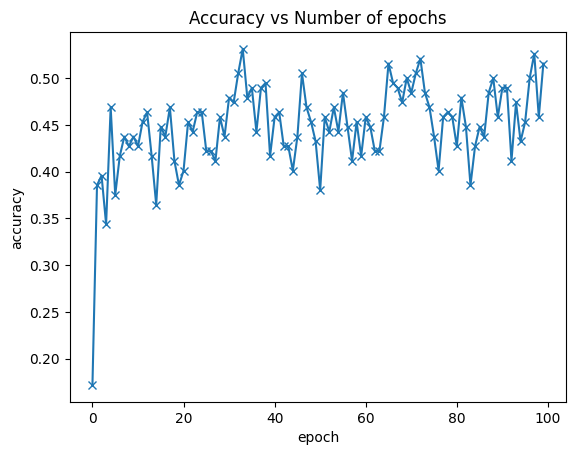

In [19]:
def plot_accuracies(history):
    accuracies = [x['validation_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Number of epochs')

plot_accuracies(history)

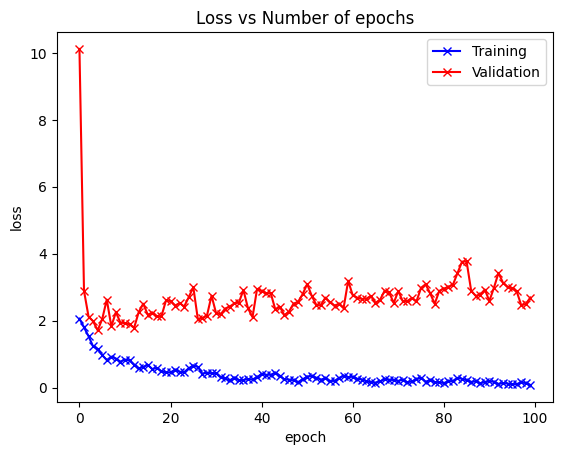

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Number of epochs')

plot_losses(history)

The model also seems to be overfitting as the training loss is getting lower but the validation loss is getting higher, however the results are much better here.

The accuracy is consistently over 40% and some points it's over 50%. However if we take the point `Epoch [4/100], Training Loss: 1.1564, Validation Loss: 1.7106, Validation Accuracy: 0.4688` as the point where validation loss goes higher while training loss drops by looking at Loss vs Number of Epochs plot, then our accuracy can be considered as `47%`

In [21]:
evaluate(model, test_dataloader)

{'validation_loss': 2.477928400039673,
 'validation_accuracy': 0.5179476141929626}

**Test Accuracy**: 51%

In [22]:
torch.save(model.state_dict(), 'resnet.pth')

In [23]:
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    for batch in loader:
        images, labels = batch
        images = to_device(images, device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds.argmax(dim=1)), dim=0)
    return all_preds

with torch.no_grad():
    all_preds = get_all_preds(model, test_dataloader, device)
    all_labels = torch.tensor([test_dataloader.dataloader.dataset.dataset.targets[i] for i in test_dataloader.dataloader.dataset.indices], dtype=torch.long)

cm = confusion_matrix(all_labels.numpy(), all_preds.cpu().numpy())


Confusion Matrix (Normalized)


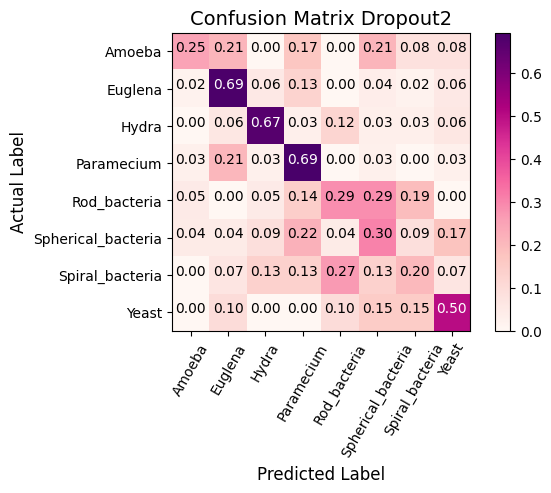

In [24]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def normalize_cm(cm: np.ndarray) -> np.ndarray:
    print("Confusion Matrix (Normalized)")
    return cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

def plot_matrix(cm, classes, cmap, title, font_size):
    tick_marks = np.arange(len(classes))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=font_size + 4)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)


def confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix Dropout2", cmap=plt.cm.RdPu):
    cm = normalize_cm(cm)

    font_size = 10
    plot_matrix(cm, classes, cmap, title, font_size)

    if normalize:
        fmt = ".2f"
    else:
        fmt = "d"

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i, format(cm[i, j], fmt), 
            horizontalalignment="center", 
            color="white" if cm[i, j] > thresh else "black", 
            size="medium"
        )

    plt.tight_layout()
    plt.ylabel("Actual Label", fontsize=font_size + 2)
    plt.xlabel("Predicted Label", fontsize=font_size + 2)

microorganism_types = ["Amoeba", "Euglena", "Hydra", "Paramecium", "Rod_bacteria", "Spherical_bacteria", "Spiral_bacteria", "Yeast"]
confusion_matrix(cm, classes=microorganism_types , normalize=True)
plt.show()
